In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device )

Device: cuda


In [3]:
df_train = pd.read_csv("train.csv")
df_val = pd.read_csv("val.csv")
df_test = pd.read_csv("test.csv")

train_labels = df_train['label'].tolist()
val_labels = df_val['label'].tolist()
test_labels = df_test['label'].tolist()

In [4]:
def load_embedding_and_mask(idx, folder_path):
    embedding = np.load(f"{folder_path}/embedding_{idx}.npy")
    mask = np.load(f"{folder_path}/mask_{idx}.npy")
    return torch.tensor(embedding, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

In [5]:
def create_batch(indices, folder_path, labels=None):
    embeddings, masks, batch_labels = [], [], []
    for idx in indices:
        emb, mask = load_embedding_and_mask(idx, folder_path)
        embeddings.append(emb)
        masks.append(mask)
        if labels is not None:
            batch_labels.append(labels[idx])

    embeddings = torch.stack(embeddings).to(device)
    masks = torch.stack(masks).to(device)

    if labels is not None:
        batch_labels = torch.tensor(batch_labels).to(device)
        return embeddings, masks, batch_labels
    else:
        return embeddings, masks


In [6]:
embedding_dim = 768
hidden_dim = 256
num_classes = 2

lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
linear = nn.Linear(hidden_dim * 2, num_classes)
lstm = lstm.to(device)
linear = linear.to(device)

In [7]:
def evaluate(lstm, linear, folder_path, labels=None, batch_size=32):
    lstm.eval()
    linear.eval()
    all_preds, all_labels = [], []
    num_samples = len(labels) if labels is not None else len(os.listdir(folder_path)) // 2

    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            batch_idx = list(range(i, min(i + batch_size, num_samples)))

            if labels is not None:
                embeddings, masks, lbls = create_batch(batch_idx, folder_path, labels)
            else:
                embeddings, masks = create_batch(batch_idx, folder_path)

            outputs, _ = lstm(embeddings)
            lengths = masks.sum(dim=1) - 1
            last_outputs = outputs[torch.arange(outputs.size(0)), lengths.long()]
            logits = linear(last_outputs)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())

            if labels is not None:
                all_labels.append(lbls.cpu())

    y_pred = torch.cat(all_preds)
    if labels is not None:
        y_true = torch.cat(all_labels)
        acc = (y_pred == y_true).float().mean().item()
        return y_pred, y_true, acc
    else:
        return y_pred

In [8]:
history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'test_acc': []}
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(lstm.parameters()) + list(linear.parameters()), lr=1e-4)
num_epochs = 5
batch_size = 32
train_folder = "train_bert_embeddings"
val_folder = "val_bert_embeddings"
test_folder = "test_bert_embeddings"

for epoch in range(num_epochs):
    lstm.train()
    linear.train()
    total_loss = 0
    all_preds, all_labels = [], []
    indices = list(range(len(train_labels)))
    np.random.shuffle(indices)

    for i in range(0, len(indices), batch_size):
        batch_idx = indices[i:i+batch_size]
        embeddings, masks, labels = create_batch(batch_idx, train_folder, train_labels)

        optimizer.zero_grad()
        outputs, _ = lstm(embeddings)
        lengths = masks.sum(dim=1) - 1
        last_outputs = outputs[torch.arange(outputs.size(0)), lengths.long()]
        logits = linear(last_outputs)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    train_acc = (torch.cat(all_preds) == torch.cat(all_labels)).float().mean().item()
    _, _, val_acc = evaluate(lstm, linear, val_folder, val_labels, batch_size=batch_size)
    _, _, test_acc = evaluate(lstm, linear, test_folder, test_labels, batch_size=batch_size)

    history['train_loss'].append(total_loss / (len(indices) / batch_size))
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['test_acc'].append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {history['train_loss'][-1]:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch 1/5 | Loss: 0.3734 | Train Acc: 0.8313 | Val Acc: 0.8773 | Test Acc: 0.8700
Epoch 2/5 | Loss: 0.2827 | Train Acc: 0.8781 | Val Acc: 0.8893 | Test Acc: 0.8902
Epoch 3/5 | Loss: 0.2486 | Train Acc: 0.8941 | Val Acc: 0.8995 | Test Acc: 0.8977
Epoch 4/5 | Loss: 0.2296 | Train Acc: 0.9031 | Val Acc: 0.8985 | Test Acc: 0.8984
Epoch 5/5 | Loss: 0.2130 | Train Acc: 0.9110 | Val Acc: 0.9023 | Test Acc: 0.9042


In [9]:
y_pred, y_true, _ = evaluate(lstm, linear, test_folder, test_labels, batch_size=batch_size)
print("\nClassification Report (Test Set):")
print(classification_report(y_true, y_pred, digits=4))


Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.8952    0.9378    0.9160      6883
           1     0.9168    0.8618    0.8884      5471

    accuracy                         0.9042     12354
   macro avg     0.9060    0.8998    0.9022     12354
weighted avg     0.9047    0.9042    0.9038     12354



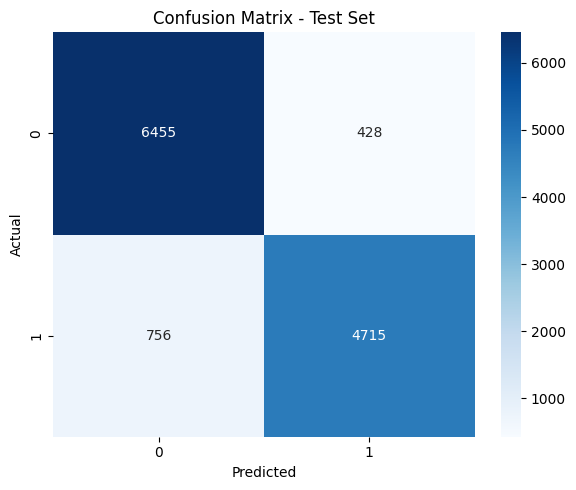

In [10]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()

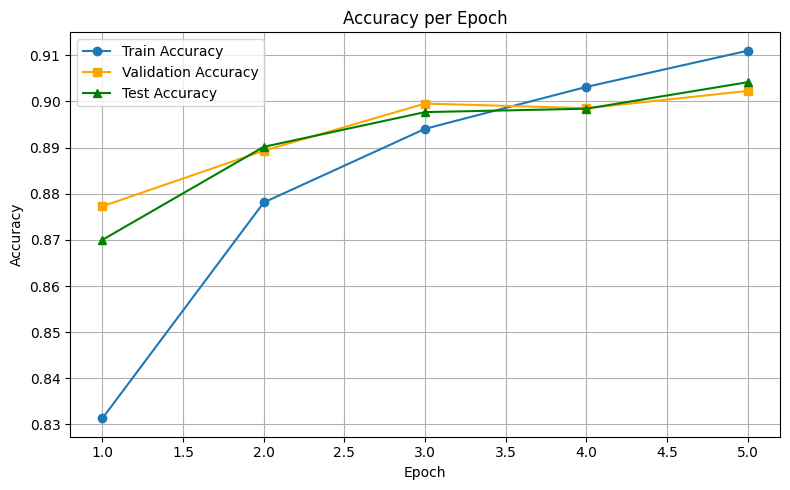

In [11]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='s', color='orange')
plt.plot(epochs, history['test_acc'], label='Test Accuracy', marker='^', color='green')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()

In [12]:
history_df = pd.DataFrame(history)
history_df.to_csv("bert_lstm_32_history.csv", index=False)

In [13]:
torch.save(lstm.state_dict(), "bert_lstm_32_model.pt")
torch.save(linear.state_dict(), "bert_lstm_32_linear.pt")